In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_precision
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, Precision, Recall, F1Score


In [2]:
selected_classes = [3, 4, 7]
pickle_dir = 'pickles'
pytorch_chkpt_dir = 'pt-saves'
pretrained_model_path = f"{pytorch_chkpt_dir}/mnist_pt.pth"

In [3]:
# create folder if not exists
os.makedirs(pickle_dir, exist_ok=True)
os.makedirs(pytorch_chkpt_dir, exist_ok=True)

In [4]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (MNIST images are 28x28)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer
        return x

In [5]:
def train_model(model, train_loader, num_epochs=20, fine_tuning=False):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Set the model to training mode
    model.train()
    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        # Create a progress bar for the current epoch
        with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in train_loader:
                # Zero the gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                # Track the running loss
                running_loss += loss.item()
                # Update the progress bar
                pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
                pbar.update(1)
    if fine_tuning:
        print("Fine-tuning complete!")
    else:
        print("Training complete!")

In [6]:
def load_from_pickle(pickle_name):
    pickled_data = pickle.load(open(f"{pickle_dir}/{pickle_name}", "rb"))
    return DataLoader(pickled_data, batch_size=32, shuffle=True)

In [7]:
def load_pretrained_model():
    model_pt = SimpleNN()
    mnist_pt = torch.load(pretrained_model_path)
    model_pt.load_state_dict(mnist_pt)
    return model_pt

In [8]:
def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables to track the predictions and true labels
    all_predictions = []
    all_labels = []
    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Forward pass: Get model predictions
            outputs = model(inputs)
            
            # Get the predicted class by finding the class with the highest score
            _, predicted = torch.max(outputs, 1)
            
            # Store the predictions and true labels for metric calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    cr = classification_report(all_labels, all_predictions)
    print(f'Classification report for tain data:\n{cr}')

    # Confusion Matrix
    # conf_matrix = confusion_matrix(all_labels, all_predictions)

In [9]:
def plot_mnist_data(loader):
    images, labels = next(iter(loader))
    # Create a grid of images (8x8) for display
    grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2, normalize=True)
    # Display the images in a grid
    plt.figure(figsize=(4, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Rearrange dimensions for matplotlib (H x W x C)
    plt.axis('off')
    plt.title("Sample MNIST Images")
    plt.show()

## Part 1: Split Data

In [10]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [11]:
# Load the MNIST training and testing datasets
mnist_train = torchvision.datasets.MNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

In [12]:
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

In [13]:
selected = {}
remaining = []
for i in mnist_train:
    if i[1] in selected_classes:
        if i[1] not in selected:
            selected[i[1]] = []
        if len(selected[i[1]]) < 1000:
            selected[i[1]].append(i)
        else:
            remaining.append(i)
    else:
        remaining.append(i)

for sc in selected:
    print(f"Class {sc} has {len(selected[sc])} samples")
    # write training datasets for fine-tuning to pickles
    pickle.dump(selected[sc], open(f"{pickle_dir}/train_{sc}.pkl", "wb"))
# write remaining dataset to separate pickle as well
print(f"Remaining list has {len(remaining)} samples")
pickle.dump(remaining, open(f"{pickle_dir}/train_rem.pkl", "wb"))

Class 4 has 1000 samples
Class 3 has 1000 samples
Class 7 has 1000 samples
Remaining list has 57000 samples


## Part 2: Train Model as Pretrained and Computation of its Functional Metrics

In [16]:
# load the data from pickle
train_loader = load_from_pickle("train_rem.pkl")
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=True)

In [15]:
# Initialize the model
model = SimpleNN()
train_model(model, train_loader, num_epochs=50)

Epoch [50/50]: 100%|██████████| 1782/1782 [00:08<00:00, 204.45batch/s, Loss=0.0179]


Training complete!


In [17]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [18]:
# load the data from pickle
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")
# Initialize the model
# model_ft_3 = load_pretrained_model()

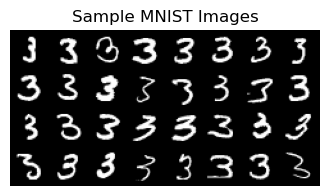

In [18]:
plot_mnist_data(train_loader_3)

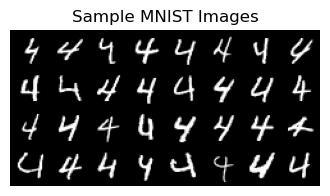

In [23]:
plot_mnist_data(train_loader_4)

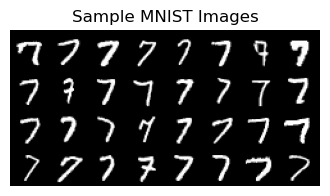

In [26]:
plot_mnist_data(train_loader_7)

In [19]:
train_model(model, train_loader_3, num_epochs=5, fine_tuning=True)

Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 294.81batch/s, Loss=0.0000]

Fine-tuning complete!


In [20]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       980
           1       0.99      0.34      0.51      1135
           2       0.94      0.57      0.71      1032
           3       0.20      1.00      0.34      1010
           4       0.99      0.77      0.87       982
           5       0.90      0.62      0.73       892
           6       0.99      0.79      0.88       958
           7       0.97      0.22      0.36      1028
           8       0.89      0.38      0.54       974
           9       0.80      0.28      0.42      1009

    accuracy                           0.58     10000
   macro avg       0.87      0.59      0.63     10000
weighted avg       0.87      0.58      0.62     10000



In [21]:
train_model(model, train_loader_4, num_epochs=5, fine_tuning=True)

Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 332.57batch/s, Loss=0.0000]

Fine-tuning complete!


In [22]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       980
           1       0.99      0.93      0.96      1135
           2       0.99      0.80      0.88      1032
           3       0.62      0.99      0.77      1010
           4       0.46      1.00      0.63       982
           5       0.98      0.67      0.80       892
           6       0.99      0.91      0.95       958
           7       0.99      0.72      0.84      1028
           8       0.96      0.85      0.90       974
           9       0.88      0.29      0.44      1009

    accuracy                           0.81     10000
   macro avg       0.89      0.81      0.81     10000
weighted avg       0.89      0.81      0.82     10000



In [23]:
train_model(model, train_loader_7, num_epochs=5, fine_tuning=True)

Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 328.04batch/s, Loss=0.0000]

Fine-tuning complete!


In [24]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.99      0.78      0.87      1135
           2       0.98      0.83      0.90      1032
           3       0.74      0.96      0.84      1010
           4       0.94      0.93      0.94       982
           5       0.99      0.67      0.80       892
           6       0.99      0.91      0.95       958
           7       0.46      1.00      0.63      1028
           8       0.96      0.83      0.89       974
           9       0.96      0.42      0.58      1009

    accuracy                           0.83     10000
   macro avg       0.90      0.83      0.84     10000
weighted avg       0.90      0.83      0.84     10000



In [25]:
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

In [26]:
train_model(model, train_loader_3, num_epochs=5, fine_tuning=True)
train_model(model, train_loader_4, num_epochs=5, fine_tuning=True)
train_model(model, train_loader_7, num_epochs=5, fine_tuning=True)

Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 203.09batch/s, Loss=0.0000]


Fine-tuning complete!


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 301.66batch/s, Loss=0.0000]


Fine-tuning complete!


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 308.58batch/s, Loss=0.0000]

Fine-tuning complete!


In [27]:
evaluate_model(model, test_loader)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       980
           1       0.99      0.79      0.88      1135
           2       0.99      0.63      0.77      1032
           3       0.70      0.97      0.81      1010
           4       0.93      0.88      0.90       982
           5       0.98      0.72      0.83       892
           6       0.98      0.93      0.95       958
           7       0.40      1.00      0.57      1028
           8       0.98      0.82      0.89       974
           9       0.97      0.20      0.33      1009

    accuracy                           0.79     10000
   macro avg       0.89      0.79      0.79     10000
weighted avg       0.89      0.79      0.79     10000



In [28]:
# Save the model
torch.save(model.state_dict(), pretrained_model_path)
print("Model saved successfully!")

Model saved successfully!
